***What is NLP?***

- Natural Language Processing
- SOTA of NLP achievements: https://github.com/sebastianruder/NLP-progress
- Useful libraries: nltk, spaCy, gensim, sklearn, fastai...

***Topic modeling with LDA, SVD, and NMF***

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress = True)

We play around with Newsgroups dataset, extracted on Usenet, which was popular before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics. 

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [4]:
print("\n".join(newsgroups_train.data[:2]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.


In [5]:
num_topics, num_top_words = 6, 8

Exploratory data analysis (EDA)

In [6]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import stop_words

In [7]:
train = pd.DataFrame({'Content': newsgroups_train.data})
label = pd.DataFrame({'Label':newsgroups_train.target})
data = pd.concat([train, label], axis =1)
data.head(5)

,Content,Label
0,"Hi,\n\nI've noticed that if you only save a mo...",1
1,"\n\nSeems to be, barring evidence to the contr...",3
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,2
3,I have a request for those who would like to s...,0
4,AW&ST had a brief blurb on a Manned Lunar Exp...,2


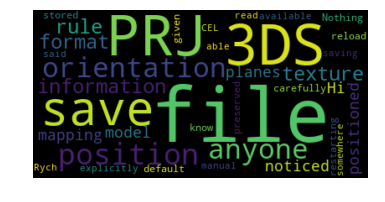

In [8]:
# Start with one content:
text = data.Content[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

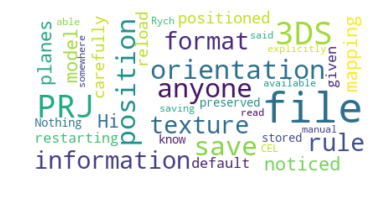

In [9]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
text = "\n".join(content for content in data.Content)
print ("There are {} words in the combination of all contents.".format(len(text)))


There are 2429863 words in the combination of all contents.


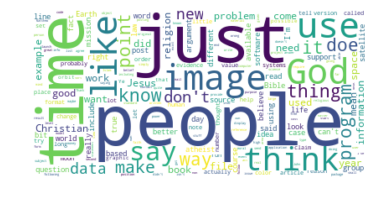

In [11]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words.ENGLISH_STOP_WORDS, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Stopword, stemming, lemmatization

In [12]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('wordnet')
from nltk import stem
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

[nltk_data] Downloading package wordnet to /home/hanh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [14]:
#Test a content
sample = data.Content.iloc[0]
print('Original conent: ', sample)
words = []
for word in sample.split(' '):
    words.append(word)
print('Tokenized and lemmatized document: ')
print(preprocess(sample))


Original conent:  Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Tokenized and lemmatized document: 
['notic', 'save', 'model', 'map', 'plan', 'posit', 'care', 'file', 'reload', 'restart', 'give', 'default', 'posit', 'orient', 'save', 'file', 'posit', 'orient', 'preserv', 'know', 'inform', 'store', 'file', 'explicit', 'say', 'manual', 'save', 'textur', 'rule', 'file', 'like', 'abl', 'read', 'textur', 'rule', 'inform', 'format', 'file'

In [15]:
processed_data = data.Content.map(preprocess)
processed_data[:5]

0    [notic, save, model, map, plan, posit, care, f...
1    [bar, evid, contrari, koresh, simpli, derang, ...
2    [articl, mark, brader, figur, unlik, actual, p...
3    [request, like, charley, wingat, respond, char...
4    [brief, blurb, man, lunar, explor, confernc, c...
Name: Content, dtype: object

In [16]:
#Create BOW containing #times a word appears in training set
dictionary = gensim.corpora.Dictionary(processed_data)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

#Filter out tokens with less than 15 docs (abs),1 docs(based on fraction of corpus),
#Keep first 100k frequent tokens
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

0 abl
1 avail
2 care
3 default
4 explicit
5 file
6 format
7 give
8 inform
9 know
10 like


In [17]:
#Gensim doc2bow - how many words and how many times those words appear per documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_data]

#preview
bow_1310 = bow_corpus[1310]
for i in range(len(bow_1310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_1310[i][0], 
                                                     dictionary[bow_1310[i][0]], 
                                                     bow_1310[i][1]))

Word 3 ("explicit") appears 1 time.
Word 6 ("give") appears 1 time.
Word 9 ("like") appears 1 time.
Word 20 ("say") appears 1 time.
Word 43 ("unlik") appears 1 time.
Word 58 ("futur") appears 1 time.
Word 67 ("mail") appears 1 time.
Word 117 ("data") appears 5 time.
Word 128 ("person") appears 1 time.
Word 130 ("sourc") appears 1 time.
Word 169 ("recent") appears 1 time.
Word 177 ("imag") appears 5 time.
Word 178 ("interest") appears 2 time.
Word 206 ("need") appears 1 time.
Word 271 ("case") appears 1 time.
Word 272 ("certain") appears 1 time.
Word 280 ("consid") appears 1 time.
Word 290 ("effort") appears 1 time.
Word 319 ("mass") appears 1 time.
Word 338 ("peopl") appears 1 time.
Word 347 ("prevent") appears 1 time.
Word 348 ("protect") appears 1 time.
Word 368 ("tri") appears 1 time.
Word 369 ("true") appears 1 time.
Word 399 ("express") appears 2 time.
Word 425 ("attent") appears 1 time.
Word 490 ("lot") appears 1 time.
Word 546 ("book") appears 4 time.
Word 552 ("creat") appears 

In [18]:
#LDA using BOW
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"space" + 0.008*"launch" + 0.007*"post" + 0.006*"nasa" + 0.006*"time" + 0.005*"program" + 0.005*"orbit" + 0.005*"satellit" + 0.005*"think" + 0.005*"problem"
Topic: 1 
Words: 0.018*"imag" + 0.009*"know" + 0.009*"space" + 0.009*"program" + 0.008*"file" + 0.008*"graphic" + 0.007*"like" + 0.007*"data" + 0.006*"peopl" + 0.006*"softwar"
Topic: 2 
Words: 0.012*"think" + 0.009*"time" + 0.008*"like" + 0.007*"space" + 0.006*"know" + 0.006*"peopl" + 0.005*"mean" + 0.005*"say" + 0.005*"object" + 0.005*"moral"
Topic: 3 
Words: 0.011*"peopl" + 0.010*"think" + 0.009*"jesus" + 0.008*"say" + 0.008*"believ" + 0.008*"know" + 0.007*"point" + 0.007*"christian" + 0.006*"thing" + 0.006*"good"


[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [19]:
#LDA using TF-IDF
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
#     pprint(doc)
    break

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"object" + 0.005*"moral" + 0.004*"space" + 0.004*"thing" + 0.004*"like" + 0.004*"know" + 0.004*"orbit" + 0.003*"valu" + 0.003*"launch" + 0.003*"card"
Topic: 1 Word: 0.005*"say" + 0.004*"think" + 0.004*"christian" + 0.004*"know" + 0.004*"peopl" + 0.004*"graphic" + 0.004*"atheist" + 0.004*"post" + 0.004*"time" + 0.004*"exist"
Topic: 2 Word: 0.006*"file" + 0.005*"space" + 0.005*"imag" + 0.004*"thank" + 0.004*"format" + 0.004*"know" + 0.004*"like" + 0.004*"think" + 0.004*"work" + 0.004*"help"
Topic: 3 Word: 0.005*"think" + 0.005*"know" + 0.005*"program" + 0.004*"peopl" + 0.004*"christian" + 0.004*"file" + 0.004*"jesus" + 0.004*"point" + 0.004*"thank" + 0.004*"bibl"


In [20]:
for index, score in sorted(lda_model_tfidf[bow_corpus[1310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.9875485897064209	 
Topic: 0.006*"file" + 0.005*"space" + 0.005*"imag" + 0.004*"thank" + 0.004*"format" + 0.004*"know" + 0.004*"like" + 0.004*"think" + 0.004*"work" + 0.004*"help"


*** Singular Value Decomposition (SVD) *** 


- Topics are **orthogonal**.
- The SVD algorithm factorizes a matrix into one matrix with **orthogonal** columns and one with **orthogonal** rows (along with a diagonal matrix, which contains the relative importance of each factor).


In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [22]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors.shape

(2034, 26576)

In [23]:
vocab = np.array(vectorizer.get_feature_names())
vocab[5000:7234]

array(['brow', 'brown', 'browning', ..., 'crumbly', 'crumbs', 'crumenam'],
      dtype='<U80')

In [28]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 42 s, sys: 1.16 s, total: 43.1 s
Wall time: 22.7 s


In [29]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [30]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [31]:
show_topics(Vh[:5])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']


*** Non-negative Matrix Factorization (NMF) *** 

- A factorization of a non-negative data set 𝑉: 𝑉 = 𝑊𝐻 into non-negative matrices 𝑊,𝐻.
-Factors into one skinny positive matrix and one short positive matrix.

--> Fast/easy to use BUT took years of research and expertise to create

In [32]:
m,n=vectors.shape
d=4  # num topics
clf = decomposition.NMF(n_components=d, random_state=1)
W1 = clf.fit_transform(vectors)
H1 = clf.components_

show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub image data ftp mail 128',
 'space launch satellite nasa commercial data satellites year',
 'jesus god people matthew atheists does atheism said']

*** Truncated SVD ***

***Pros***
- Inherently stable.
- Independent of subtle spectral properties.
- Needed matrix-vector products can be done in parallel.

***Cons***:
- Matrices are "stupendously big".
- Data are often **missing or inaccurate**. 
- **Data transfer**.
- Important to take advantage of **GPUs**.

(source: [Halko](https://arxiv.org/abs/0909.4061))